In [425]:
import pandas as pd
import openai
import time
import re
from scipy import stats
from sklearn.metrics import mean_absolute_error
import pickle
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
import datetime 
import sys
sys.path.append('../experiment_01')
from sidemethods import logprobs_from_prompt, proc, proc_lower, prob_of_ending
import torch
import random
cuda_avail=torch.cuda.is_available()
print('cuda available:', cuda_avail)

RATE_LIMIT = 0.5 # seconds of pause needed after every OpenAI API call


with open("../../hf.key", "r") as f_in:
    hf_key = f_in.readline().strip()

api_key = open('openai.key', 'r').read()
openai.api_key = api_key

cuda available: False


In [135]:
#%cd Image-Schemas-in-LLMs/src/experiment_02

# Prompt Preperation and Helper Methods

In [136]:
exp_2_df = pd.read_csv('../../data/Beitel_Exp2.csv', sep=';')
exp_3_df = pd.read_csv('../../data/Gibbs_Exp3.csv', sep=';')
# drop nan rows
exp_3_df = exp_3_df.dropna()
exp_4_df = pd.read_csv('../../data/Gibbs_Exp4.csv', sep=';')
STIMULI_EXP2 = exp_2_df['Stimulus'].values
STIMULI_EXP3 = exp_3_df['Stimulus'].values
STIMULI_EXP4 = exp_4_df['Stimulus'].values
print(len(STIMULI_EXP2))
print(len(STIMULI_EXP3))
print(len(STIMULI_EXP4))

37
32
32


Description from Gibbs paper: 
- The participants in this study were first asked to stand up and focus on different aspects of their bodily experience of standing in the same way as did participants in Experiment 1.
- Following this, we introduced the five image schemas of BALANCE, VERTICALITY, CENTER-PERIPHERY, RESISTANCE, and LINKAGE as was done in Experiment 1


Description from Beitel paper:
- Prior to the experiment, the participants received the descriptions of all five image schemas in relation to a sample typical use of on. The sample use of on was not included as the test item.

In [281]:
DEFINITIONS = {
    "VERTICALITY": "Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.",
    "BALANCE": "Consider the notion of BALANCE. Balance refers to your sense of symmetry or stability relative to some point within your body.",
    "CENTER-PERIPHERY": "Consider the notion of CENTER-PERIPHERY. Center-periphery refers to the experience of some objects or events as central while surrounding objects and events are peripheral or to the outside.",
    "LINKAGE": "Consider the notion of LINKAGE. Linkage refers to the perception of a connection between objects or events.",
    "RESISTANCE": "Consider the notion of RESISTANCE. Resistance refers to the experience of your body opposing some external force."
}

DEFINITIONS_2_INTRO='In the case of the use of "on" in "the book is on the desk":'
DEFINITIONS_2 = {
    "SUPPORT": "the SUPPORT relation refers to the desk supporting the book.",
    "PRESSURE": "the PRESSURE relation refers to the book exerting some pressure on the desk.",
    "CONSTRAINT": "the CONSTRAINT relation refers to the desk constraining the possible motions of the book.",
    "COVERING": "the COVERING relation refers to the book concealing the part of the desk that is under the book.",     #TODO mention ";" changed to "."
    "VISIBILITY": "the VISIBILITY relation refers to the book being visible on the desk."
}

In [282]:
# create prompts
prompts_exp2 = {"SUPPORT":[], "PRESSURE":[], "CONSTRAINT":[], "COVERING":[], "VISIBILITY":[]}
prompts_exp3 = {"VERTICALITY":[], "BALANCE":[], "CENTER-PERIPHERY":[], "LINKAGE":[], "RESISTANCE":[]}
prompts_exp4 = {"VERTICALITY":[], "BALANCE":[], "CENTER-PERIPHERY":[], "LINKAGE":[], "RESISTANCE":[]}



for i in range(len(STIMULI_EXP2)):
    for key in DEFINITONS_2:
        prompt_ending =  'On a scale from 1 (not at all appropriate) to 7 (very appropriate), how appropriate is the concept '+key+' in regards to the phrase: "' + STIMULI_EXP2[i] + '"?'
        prompts_exp2[key].append(DEFINITIONS_2_INTRO + " " + DEFINITIONS_2[key] + "\n" + prompt_ending)

for i in range(len(STIMULI_EXP3)):
    prompt_ending =  'How strongly is the phrase "' + STIMULI_EXP3[i] + '" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?'
    prompts_exp3["VERTICALITY"].append(DEFINITIONS["VERTICALITY"] + "\n" + prompt_ending)
    prompts_exp3["BALANCE"].append(DEFINITIONS["BALANCE"] + "\n" + prompt_ending)
    prompts_exp3["CENTER-PERIPHERY"].append(DEFINITIONS["CENTER-PERIPHERY"] + "\n" + prompt_ending)
    prompts_exp3["LINKAGE"].append(DEFINITIONS["LINKAGE"] + "\n" + prompt_ending)
    prompts_exp3["RESISTANCE"].append(DEFINITIONS["RESISTANCE"] + "\n" + prompt_ending)

for i in range(len(STIMULI_EXP4)):
    prompt_ending =  'How strongly is the phrase "' + STIMULI_EXP4[i] + '" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?'
    prompts_exp4["VERTICALITY"].append(DEFINITIONS["VERTICALITY"] + "\n" + prompt_ending)
    prompts_exp4["BALANCE"].append(DEFINITIONS["BALANCE"] + "\n" + prompt_ending)
    prompts_exp4["CENTER-PERIPHERY"].append(DEFINITIONS["CENTER-PERIPHERY"] + "\n" + prompt_ending)
    prompts_exp4["LINKAGE"].append(DEFINITIONS["LINKAGE"] + "\n" + prompt_ending)
    prompts_exp4["RESISTANCE"].append(DEFINITIONS["RESISTANCE"] + "\n" + prompt_ending)

# example prompts
print(prompts_exp2["SUPPORT"][0], "\n")
print(prompts_exp3["BALANCE"][0])

In the case of the use of "on" in "the book is on the desk": the SUPPORT relation refers to the desk supporting the book.
On a scale from 1 (not at all appropriate) to 7 (very appropriate), how appropriate is the concept SUPPORT in regards to the phrase: "The family depends on the father"? 

Consider the notion of BALANCE. Balance refers to your sense of symmetry or stability relative to some point within your body.
How strongly is the phrase "stand at attention" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?


In [139]:
# variants with which GPT can be prompted to generate the questionnaire answers
def gpt_complete(prompt, model, max_tokens, prompt_ending, verbose=False):
    temperature = 0
    prompt=prompt+prompt_ending
    if verbose: print("Prompt:", prompt)
    # the create functiosn differ for chat and non-chat models
    if "turbo" in model and not "instruct" in model:
        system_message="You are a participant in a research experiment."
        return openai.ChatCompletion.create(
            model=model,
            messages=[ {"role": "system", "content": system_message},
                {"role": "user", "content": prompt}],
            temperature=temperature,
            max_tokens=max_tokens
            )
    else:
        return openai.Completion.create(
            model=model,
            prompt=prompt,
            temperature=temperature,
            max_tokens=max_tokens
        ) 

def gpt_complete_proba(prompt, model, prompt_ending, verbose=False):
    # get the probability distribution over the next token for the tokens 1, 2, 3, 4, 5, 6, 7
    temperature = 0
    proba_list = []
    debug = []
    for i in range(1, 8):
        next_prompt = prompt + prompt_ending + str(i)
        if verbose: print("Prompt:", next_prompt)
        
        if "turbo" in model and not "instruct" in model:
            system_message="You are a participant in a research experiment."
            result = openai.ChatCompletion.create(                                          # TODO: add logprobs once available in the API! 
                model=model,
                messages=[ {"role": "system", "content": system_message},
                    {"role": "user", "content": next_prompt}],
                temperature=temperature,
                max_tokens=1,
            )

        else:
            result = openai.Completion.create(
                model=model,
                prompt=next_prompt,
                max_tokens=1,
                temperature=temperature,
                logprobs=1,
                echo=True
            )
        debug.append(result)
        print(result["choices"][0]["logprobs"]["tokens"])
        # the index of i in the list of tokens
        tokens = result["choices"][0]["logprobs"]["tokens"]
        # strip whitespace
        tokens = [tok.strip() for tok in tokens]
        index = [num for num, tok in enumerate(tokens) if tok == str(i)][-1]
        print("index:", index)
        print("log prob:", result["choices"][0]["logprobs"]["token_logprobs"][index])
        print("prob:", np.exp(result["choices"][0]["logprobs"]["token_logprobs"][index]))
        print("token:", result["choices"][0]["logprobs"]["tokens"][index])
        print()
        log_prob_result=result["choices"][0]["logprobs"]["token_logprobs"][index]
        prob_result = np.exp(log_prob_result)
        proba_list.append(prob_result)
        # wait 20 seconds to avoid exceeding the API rate limit
        time.sleep(RATE_LIMIT)      
    average_completion = 0
    for i in range(1, 8):
        average_completion += i * proba_list[i-1]
    average_completion = average_completion / sum(proba_list)      # TODO: verify this is the right operation

    return proba_list, average_completion, debug


def gpt_one_IS_all_stimuli(model, image_schema, stimuli):     
    '''
    given one image schema, rate all stimuli
    '''           
    prompt = DEFINITIONS[image_schema]
    prompt += "\n\n" + "Rate the following 32 stimuli on a scale from 1 (not at all related) to 7 (very strongly related) in regards to how related they are to this notion: \n"
    for i in range(1, len(stimuli)+1):
        prompt += str(i) + ": "+ stimuli[i-1] + "\n"
    return gpt_complete(prompt, model)

def gpt_with_full_instructions(model, stimuli):
    '''
    TODO: can be removed as not close enough to the real experiment from the paper
    '''
    prompt = ""
    for d in DEFINITIONS.values():
        prompt += d + "\n\n"
    prompt += "Rate the following "+len(stimuli)+" stimuli on a scale from 1 (not at all related) to 7 (very strongly related) in regards to how related they are to these 5 notions. You will need to provide 5 scores per stimulus: \n"
    for i in range(1, len(stimuli)+1):
        prompt += str(i) + ": "+ stimuli[i-1] + "\n"
    prompt += "\n\n" +"Give each stimulus 5 ratings (VERTICALITY, BALANCE, CENTER-PERIPHERY, LINKAGE, RESISTANCE): "
    return gpt_complete(prompt, model)
    
# TODO: For future experiments: 
def gpt_simulate_human(prompt, model, name, gender):           # TODO: Future work, TE paradigm 
    prompt = name + " was asked to..." + name +" responded with the number: " + prompt
    return gpt_complete(prompt, model)

def gpt_complete_reasoning(prompt, model):
    prompt += "Reason step by step: \n"
    return gpt_complete(prompt, model)

In [141]:
def hf_complete(prompt, model, tokenizer, sampling, max_len):
    # get completion from hf_model
    # Step 1: Tokenize the prompt
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    
    # Step 2: Generate the model input
    if sampling:
        # TODO make sampling params explicit --> temp, top_k
        output = model.generate(input_ids, max_new_tokens=max_len, num_return_sequences=1)
    else: 
        output = model.generate(input_ids, max_new_tokens=max_len, num_return_sequences=1, top_k=1)
        
    
    # Step 3: Decode the generated output to get the answer
    generated_answer = tokenizer.decode(output[0], skip_special_tokens=True)
    
    # Step 4: Print the answer
    return generated_answer

def hf_complete_proba(prompt, model):
    pass

def hf_with_nearly_full_instructions(model, tokenizer, image_schema, stimuli, sampling):
    prompt = DEFINITIONS[image_schema]
    prompt += "\n\n" + "Rate the following 32 stimuli on a scale from 1 (not at all related) to 7 (very strongly related) in regards to how related they are to this notion: \n"
    for i in range(1, len(stimuli)+1):
        prompt += str(i) + ": "+ stimuli[i-1] + "\n"
    return hf_complete(prompt=prompt, model=model, tokenizer=tokenizer, sampling=sampling, max_len=500)

def hf_with_full_instructions(model, tokenizer, stimuli, sampling):
    prompt = ""
    for d in DEFINITIONS.values():
        prompt += d + "\n\n"
    prompt += "Rate the following 32 stimuli on a scale from 1 (not at all related) to 7 (very strongly related) in regards to how related they are to these 5 notions. You will need to provide 5 scores per stimulus: \n"
    for i in range(1, len(stimuli)+1):
        prompt += str(i) + ": "+ stimuli[i-1] + "\n"
    prompt += "\n\n" +"Give each stimulus 5 ratings (VERTICALITY, BALANCE, CENTER-PERIPHERY, LINKAGE, RESISTANCE): "
    return hf_complete(prompt=prompt, model=model, tokenizer=tokenizer, sampling=False, max_len=100)

In [439]:
# test the functions
# for model choices see: https://platform.openai.com/docs/models/gpt-3-5 

print(gpt_complete(prompt=prompts_exp2["VISIBILITY"][5], model="davinci-002", max_tokens=10, prompt_ending="")) #davinci, davinci-002, text-davinci-003

{
  "id": "cmpl-8Bg5Ru5OjpxmhfrLrNKnWsd1Ut4EN",
  "object": "text_completion",
  "created": 1697794081,
  "model": "davinci-002",
  "choices": [
    {
      "text": " 1 2 3 4 5",
      "index": 0,
      "logprobs": null,
      "finish_reason": "length"
    }
  ],
  "usage": {
    "prompt_tokens": 72,
    "completion_tokens": 10,
    "total_tokens": 82
  }
}


# Finding a Good Way of How to End a Prompt 
(maximize valid answers without looking at the content of the answer)

In [142]:
# the standard prompt:
print(prompts_exp3["VERTICALITY"][0])

Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.
How strongly is the phrase "stand at attention" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?


In [143]:
# compute the sum of log probabilities attributed to the 7 allowed scores over X samples
def log_prob_sum(input_samples, model, prompt_ending):
    proba_sum = 0
    avg_output_list = []
    for prompt in input_samples:
        proba_list, avg_likert, debug = gpt_complete_proba(prompt, model, prompt_ending, verbose=True)
        proba_sum += sum(proba_list)
        avg_output_list.append(avg_likert)
    return proba_sum, avg_output_list       # return sum and the list of average likert scores per prompt


The following endings will be tested:
- "\n\n"
- "\n"
- "Only answer with the score: \n\n"
- "I choose the score"

We will also check if the content of the ouput differs a lot or stays rather similar.

In [148]:
model = "text-davinci-003"      #"davinci-002"
test_inputs=[]
score_sums=[]
for k in prompts_exp3:
    for p in prompts_exp3[k][0:3]:         # --> 3 items x 5 IS * 7 scale answers= 105 prompts * 6 endings = 630 prompts
        test_inputs.append(p)                                                                    
print(test_inputs)    
print("Number of inputs used to compute probability sum:", len(test_inputs))     


prompt_endings=[" Only answer with the score: \n\n", "\n\n", "\n", " Only answer with the score! \nI choose the score ", " A research participant would choose the number \n", " I choose the number "]
output_lists=[]             # list containing the avg. generated likert scores 
for ending in prompt_endings:
    print("Testing Prompt Ending:", ending)
    proba_sum, output_list=log_prob_sum(test_inputs, model, prompt_ending=ending)
    score_sums.append(proba_sum)   
    output_lists.append(output_list)

# print results
for i in range(len(prompt_endings)):
    print("Prompt Ending:", prompt_endings[i].replace("\n", "\\n"))
    print("Probability Sum:", score_sums[i])
    print("Average Probability:", score_sums[i]/len(test_inputs))
    # compute avg. difference in output_list to the other output_lists
    for j in range(len(prompt_endings)):
        if i!=j:
            print("Average score difference to Prompt Ending", prompt_endings[j].replace("\n","\\n"), ":", 
                  np.mean(np.abs(np.array(output_lists[i])-np.array(output_lists[j]))))
    print()


['Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.\nHow strongly is the phrase "stand at attention" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?', 'Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.\nHow strongly is the phrase "stand out in several sports" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?', 'Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.\nHow strongly is the phrase "to stand firm" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?', 'Consider the notion of BALANCE. Balance refers to your sense of symmetry or stability relative to some point within your body.\nHow strongly is the phrase "stand at attention" related to this notion on a scale from 1 (no

# Analysis Helpers

In [395]:
def make_bar_plots_gibbs(model_result_dict_3, model_result_dict_4, title):
    # Visualize results as bar charts with 2 bars per key (one for each experiment) and each bar being the correlation coefficient
    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.xlabel("Image Schema")
    plt.ylabel("Spearman Correlation Coefficient")
    # set y axis to 0.0 to 1.0
    plt.ylim(0.0, 1.0)
    # set y ticks to 0.0, 0.2, 0.4, ..., 1.0
    plt.yticks(np.arange(0.0, 1.1, 0.2))
    for key in DEFINITIONS:
        # the bars of the two experiments are next to each other
        plt.bar(key, stats.spearmanr(model_result_dict_3[key], exp_3_df[key])[0], width=0.4, color='orange')
        # move the bar to the right
        plt.bar(key, stats.spearmanr(model_result_dict_4[key], exp_4_df[key])[0], width=0.4, align='edge', color='blue')
    plt.legend(["Experiment 3", "Experiment 4"])
    plt.grid(axis='y')
    plt.show()

def make_bar_plots_beitel(model_result_dict_2, title):
    # Visualize results as bar charts with 2 bars per key (one for each experiment) and each bar being the correlation coefficient
    plt.figure(figsize=(12, 4))
    plt.title(title)
    plt.xlabel("Image Schema")
    plt.ylabel("Spearman Correlation Coefficient")
    # set y axis to 0.0 to 1.0
    plt.ylim(0.0, 1.0)
    # set y ticks to 0.0, 0.2, 0.4, ..., 1.0
    plt.yticks(np.arange(0.0, 1.1, 0.2))
    for key in DEFINITIONS_2:
        # the bars of the two experiments are next to each other
        plt.bar(key, stats.spearmanr(model_result_dict_2[key], exp_2_df[key])[0], width=0.4, color='red')
        # move the bar to the right
    plt.legend(["Experiment 2"])
    plt.grid(axis='y')
    plt.show()

def make_bar_plots_all(model_result_dict_2, model_result_dict_3, model_result_dict_4, title):
    # exp2 has different keys than exp3 and exp4
    # Visualize results as bar charts with 3 bars per xtick, the x labels being the image schemas and the bars being the correlation coefficient
    plt.figure(figsize=(16, 5))
    plt.title(title)
    plt.xlabel("Image Schema")
    plt.ylabel("Spearman Correlation Coefficient")
    # set y axis to 0.0 to 1.0
    plt.ylim(0.0, 1.0)
    # set y ticks to 0.0, 0.2, 0.4, ..., 1.0
    plt.yticks(np.arange(0.0, 1.1, 0.2))
    for i, key in enumerate(DEFINITIONS_2):
        # the bars of the two experiments are next to each other
        plt.bar(i-0.25, stats.spearmanr(model_result_dict_2[key], exp_2_df[key])[0], width=0.25, color='red')
    for i, key in enumerate(DEFINITIONS):
        # move the bar to the right
        plt.bar(i, stats.spearmanr(model_result_dict_3[key], exp_3_df[key])[0], width=0.25, color='orange')
        # move the bar to the right
        plt.bar(i+0.25, stats.spearmanr(model_result_dict_4[key], exp_4_df[key])[0], width=0.25, color='blue')
    # change x labels to image schema names
    labels = []
    for key in DEFINITIONS_2:
        labels.append(key)
    for j, key in enumerate(DEFINITIONS):
        labels[j]+= "/" + key
    plt.xticks(np.arange(len(labels)), labels)
    # add grid
    plt.grid(axis='y')


def make_scatter_plots_beitel(model_result_dict_2, title):
    # plot side by side, 5 plots
    fig, axs = plt.subplots(1, 5, figsize=(20, 3))
    fig.suptitle(title)
    plt.tight_layout()
    # add space between title and plots
    #fig.subplots_adjust(top=0.2)
    for i, key in enumerate(DEFINITIONS_2):
        # add scatter plot
        axs[i].scatter(model_result_dict_2[key], exp_2_df[key], color='red')
        axs[i].set_title(key)
        if i==0: axs[i].set_ylabel("Human Rating (Exp 2)")
        axs[i].set_xlabel("GPT Rating")
        # set x and y limits to 0 to 7.2
        axs[i].set_xlim(0.7, 7.2)
        axs[i].set_ylim(0.7, 7.2)
        # set x and y ticks to 0, 1, 2, ..., 7
        axs[i].set_xticks(np.arange(1, 8, 1))
        axs[i].set_yticks(np.arange(1, 8, 1))
        # add correlation coefficient to each plot
        axs[i].text(0.05, 0.95, "r = " + str(round(stats.spearmanr(model_result_dict_2[key], exp_2_df[key])[0], 2)), transform=axs[i].transAxes, fontsize=12, verticalalignment='top')

def make_scatter_plots_gibbs(model_result_dict_3, model_result_dict_4, title):
    # plot side by side, 5 plots
    fig, axs = plt.subplots(2, 5, figsize=(20, 6))
    fig.suptitle(title)
    for i, key in enumerate(DEFINITIONS):
        axs[0, i].scatter(model_result_dict_3[key], exp_3_df[key], color='orange')
        axs[0, i].set_title(key)
        if i==0: axs[0, i].set_ylabel("Human Rating (Exp 3)")
        axs[1, i].scatter(model_result_dict_4[key], exp_4_df[key], color='blue')
        axs[1, i].set_xlabel("GPT Rating")
        if i ==0: axs[1, i].set_ylabel("Human Rating (Exp 4)")
        # set x and y limits to 0 to 7.2
        axs[0, i].set_xlim(0.7, 7.2)
        axs[0, i].set_ylim(0.7, 7.2)
        axs[1, i].set_xlim(0.7, 7.2)
        axs[1, i].set_ylim(0.7, 7.2)
        # set x and y ticks to 0, 1, 2, ..., 7
        axs[0, i].set_xticks(np.arange(1, 8, 1))
        axs[0, i].set_yticks(np.arange(1, 8, 1))
        axs[1, i].set_xticks(np.arange(1, 8, 1))
        axs[1, i].set_yticks(np.arange(1, 8, 1))
        # add correlation coefficient to each plot
        axs[0, i].text(0.05, 0.95, "r = " + str(round(stats.spearmanr(model_result_dict_3[key], exp_3_df[key])[0], 2)), transform=axs[0, i].transAxes, fontsize=12, verticalalignment='top')
        axs[1, i].text(0.05, 0.95, "r = " + str(round(stats.spearmanr(model_result_dict_4[key], exp_4_df[key])[0], 2)), transform=axs[1, i].transAxes, fontsize=12, verticalalignment='top')

def print_correlations(completions_clean, exp_df, correlation_type):
    if correlation_type == "spearman":
        print("Spearman correlations per IS:")
        for k in completions_clean:
            print(k, stats.spearmanr(completions_clean[k], exp_df[k]))
    elif correlation_type == "pearson":
        print("Pearson correlations per IS:")
        for k in completions_clean:
            print(k, stats.pearsonr(completions_clean[k], exp_df[k]))

def get_mean_absolute_error(completions, exp_df):
    print("The mean absolute error for each image schema is: ")
    for key in completions:
        print(key, mean_absolute_error(completions[key], exp_df[key]))

In [242]:
def save_generations_to_csv(completions_clean, stimuli, exp_name, completions=None):    #completions is a dict with IS as keys and completions as values
    # ratings
    df = pd.DataFrame.from_dict(completions_clean)
    # stimuli
    df.insert(0, 'Stimulus', stimuli)
    # original completions
    completions_text={}     
    if completions != None:
        for k in completions:
            completions_text[k]=[]
            for i in range(len(completions[k])):
                completions_text[k].append(completions[k][i]["choices"][0]["text"])
        # add to df as last column
        for k in completions_text:
            df.insert(len(df.columns),  k+"_Completion_Text", completions_text[k])

    date = datetime.datetime.now().strftime("%Y-%m-%d")
    df.to_csv('lm_generations/df_' + exp_name + '_' + date + '.csv', index=False)
    print('Saved as df_' + exp_name + '_' + date + '.csv')

In [ ]:
#def image_schema_profile_accuracy(completions, human_data):
#    image_schema_rankings_humans = []
#    # 
# TODO: this doesnt make sense when multiple ISs can have the same score

# Huggingface Model Experiments

In [19]:
hf_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-13b-hf", cache_dir="../../../models/l13b", token=hf_key)
hf_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-13b-hf",  cache_dir="../../../models/l13b", token=hf_key)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [22]:
hf_complete(prompt="love love", model=hf_model, tokenizer=hf_tokenizer, sampling=False, max_len=5)

"love love love this! I'"

In [ ]:
start = "nazis are known to be on the political "
answers = {0:"left", 1:"right"}

res_ends = []
for j, end in answers.items():
    input_prompt = proc(start) + ' ' + proc(end)
    print(input_prompt)
    logprobs = logprobs_from_prompt(input_prompt, hf_tokenizer, hf_model)
    res = {"tokens": [x for x,y in logprobs],"token_logprobs": [y for x,y in logprobs]}
    res_ends.append(res)
    print(end)
    print(res)
    print()
print(res_ends)

# Full Questionnaire Experiment (as close as possible to the real one)

5 lists of image schema orders. After each image schema is introduced, the participants rates all 32 items.

In [449]:
image_schema_orders = []
for i in range(5):
    # add state to random
    random.seed(i)
    image_schema_order = random.sample(DEFINITIONS.keys(), len(DEFINITIONS.keys()))
    image_schema_orders.append(image_schema_order)

stimuli_orders = {}
for j, key in enumerate(DEFINITIONS.keys()):
    stimuli_orders[key] = []
    for i in range(2):  # in principle there are two blocks, but we only use one to check the general result trend (as it isn't great anyways)
        random.seed(j*2+i)
        # the integers 0 to 31 in random order
        stimuli_order = random.sample(range(0, 32), 32)
        stimuli_orders[key].append(stimuli_order)


def gpt_realistic_prompt(model, stimuli_orders, image_schema_orders):
    ''' 
    version as close to the paper as possible: 
    --> The order of image schemas in the booklet was counterbalanced across five lists of materials.
    The order of the 32 senses of stand was counterbalanced in two blocks for each image schema.
    '''
    # do the 5 different orders
    completions = []
    for order in image_schema_orders:
        prompt = ""
        # image schema per order with all 32 stimuli
        for image_schema in order:
            prompt += DEFINITIONS[image_schema]
            prompt += "\n\n" + "Rate the following 32 stimuli on a scale from 1 (not at all related) to 7 (very strongly related) in regards to how related they are to the notion of "+image_schema+": \n"
            for i in range(1, len(STIMULI_EXP3)+1): 
                prompt += str(i) + ": "+ STIMULI_EXP3[stimuli_orders[image_schema][0][i-1]] + "\n"
            prompt += "\n"
            print("prompt:", prompt)
            # get gpt completion
            result = gpt_complete(prompt, model, max_tokens=400, prompt_ending="")
            # add result text to prompt
            prompt += result["choices"][0]["text"] + "\n\n"
            print("output:", result)
        completions.append(prompt)
    return completions 



/var/folders/bv/9t03hlvd6jv_vzfmf4gqhkfm0000gn/T/ipykernel_93051/2974971586.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  image_schema_order = random.sample(DEFINITIONS.keys(), len(DEFINITIONS.keys()))


In [450]:
completions_realistic = gpt_realistic_prompt("text-davinci-003", stimuli_orders, image_schema_orders)

prompt: Consider the notion of LINKAGE. Linkage refers to the perception of a connection between objects or events.

Rate the following 32 stimuli on a scale from 1 (not at all related) to 7 (very strongly related) in regards to how related they are to the notion of LINKAGE: 
1: united we stand
2: on the witness stand
3: as the matter now stands
4: let the mixture stand
5: stand out in several sports
6: stand at attention
7: to stand the test of time
8: to stand accused
9: stand by your man
10: the boss always stands over me
11: the clock stands on the mantle
12: he stands six-foot nine
13: it stands to reason
14: to stand against great odds
15: the house stands in the clearing
16: we stand on 30 years of experience
17: to stand to profit
18: to stand in someone else's shoes
19: the barometer stands at 30 inches
20: the police told them to stand back
21: stand on shaky ground
22: they did nothing but stand around
23: don't stand for such treatment
24: one-night stand
25: the part stand

In [451]:
# save completions_realistic to pkl
if True:
    with open('completions_realistic.pkl', 'wb') as f:
        pickle.dump(completions_realistic, f)

In [452]:
completions_realistic

["Consider the notion of LINKAGE. Linkage refers to the perception of a connection between objects or events.\n\nRate the following 32 stimuli on a scale from 1 (not at all related) to 7 (very strongly related) in regards to how related they are to the notion of LINKAGE: \n1: united we stand\n2: on the witness stand\n3: as the matter now stands\n4: let the mixture stand\n5: stand out in several sports\n6: stand at attention\n7: to stand the test of time\n8: to stand accused\n9: stand by your man\n10: the boss always stands over me\n11: the clock stands on the mantle\n12: he stands six-foot nine\n13: it stands to reason\n14: to stand against great odds\n15: the house stands in the clearing\n16: we stand on 30 years of experience\n17: to stand to profit\n18: to stand in someone else's shoes\n19: the barometer stands at 30 inches\n20: the police told them to stand back\n21: stand on shaky ground\n22: they did nothing but stand around\n23: don't stand for such treatment\n24: one-night stan

In [454]:
# clean up
completions_realistic_clean = []
for i, c in enumerate(completions_realistic):
    completions_realistic_clean.append({})
    for key in image_schema_orders[i]:
        completions_realistic_clean[i][key] = []
        # clean the completion c 
        # split by image schema
        c_split = c.split("Consider the notion of")
        # find the string that contains the key
        c_relevant = [s for s in c_split if key in s]
        print("c_rel for", key, c_relevant)
        # get the scores 
        for s in c_relevant:
            scores = re.findall(r'\d+\n', s)
            # only keep the numbers
            scores = [int(s.strip()) for s in scores]
            print("scores:", scores)
            if len(scores) != len(STIMULI_EXP3):
                # throw an error
                raise ValueError("Not all scores were found for image schema "+key)
            else:
                print("all", len(scores), "scores found for image schema", key,"\n")

            completions_realistic_clean[i][key]=scores

c_rel for LINKAGE [" LINKAGE. Linkage refers to the perception of a connection between objects or events.\n\nRate the following 32 stimuli on a scale from 1 (not at all related) to 7 (very strongly related) in regards to how related they are to the notion of LINKAGE: \n1: united we stand\n2: on the witness stand\n3: as the matter now stands\n4: let the mixture stand\n5: stand out in several sports\n6: stand at attention\n7: to stand the test of time\n8: to stand accused\n9: stand by your man\n10: the boss always stands over me\n11: the clock stands on the mantle\n12: he stands six-foot nine\n13: it stands to reason\n14: to stand against great odds\n15: the house stands in the clearing\n16: we stand on 30 years of experience\n17: to stand to profit\n18: to stand in someone else's shoes\n19: the barometer stands at 30 inches\n20: the police told them to stand back\n21: stand on shaky ground\n22: they did nothing but stand around\n23: don't stand for such treatment\n24: one-night stand\n2

In [456]:
stimuli_orders["VERTICALITY"][0]

[24,
 31,
 28,
 13,
 1,
 8,
 16,
 15,
 12,
 9,
 30,
 11,
 18,
 6,
 25,
 4,
 22,
 2,
 23,
 27,
 21,
 17,
 26,
 14,
 10,
 0,
 5,
 19,
 20,
 29,
 7,
 3]

In [457]:
# resort completions_realistic_clean to match the original order, not the random order from stimuli_orders
completions_realistic_clean_resorted = []
for i in range(5):
    completions_realistic_clean_resorted.append({})
    for key in DEFINITIONS.keys():
        completions_realistic_clean_resorted[i][key] = []
        for j in range(len(stimuli_orders[key][0])): # j is just a number from 0 to 31
            # get the index of the j-th item in the random order
            index = stimuli_orders[key][0].index(j) # the new index of that (original order) item
            ordered_item = completions_realistic_clean[i][key][index] # the item is at that new index 
            completions_realistic_clean_resorted[i][key].append(ordered_item)

In [467]:
for c in completions_realistic_clean:
    print(c)

{'LINKAGE': [6, 6, 6, 5, 5, 6, 6, 6, 5, 5, 5, 5, 6, 6, 5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 6, 6, 5, 5, 5, 6, 5, 6], 'RESISTANCE': [5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5], 'VERTICALITY': [5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 6, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5], 'BALANCE': [5, 6, 5, 6, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5], 'CENTER-PERIPHERY': [6, 5, 6, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5]}
{'BALANCE': [2, 6, 4, 5, 7, 3, 1, 5, 4, 5, 4, 6, 4, 6, 4, 5, 4, 5, 6, 5, 4, 5, 4, 5, 6, 5, 4, 6, 5, 4, 5, 6], 'VERTICALITY': [4, 5, 6, 5, 6, 5, 6, 5, 4, 4, 5, 6, 4, 6, 5, 6, 5, 6, 7, 4, 5, 4, 5, 5, 6, 5, 6, 4, 4, 6, 4, 2], 'RESISTANCE': [5, 6, 4, 6, 6, 5, 6, 6, 6, 4, 6, 4, 6, 5, 5, 5, 4, 4, 5, 4, 2, 5, 5, 5, 5, 5, 4, 4, 5, 4, 7, 6], 'LINKAGE': [6, 5, 4, 5, 6, 5, 6, 5, 4, 5, 6, 5, 5, 6, 5, 6, 5, 5, 7, 4, 4, 4, 2, 4, 5, 5, 4, 4, 4, 6, 6

In [466]:
for c in completions_realistic_clean_resorted:
    print(c)

{'VERTICALITY': [5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5], 'BALANCE': [5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5], 'CENTER-PERIPHERY': [6, 6, 6, 6, 6, 5, 6, 6, 5, 5, 6, 6, 5, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6], 'LINKAGE': [6, 5, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 6, 5, 5, 6, 6, 6, 5, 6, 6, 5, 6], 'RESISTANCE': [5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5]}
{'VERTICALITY': [5, 6, 6, 2, 6, 6, 6, 4, 5, 4, 6, 6, 4, 5, 5, 5, 6, 4, 4, 4, 4, 5, 5, 7, 4, 5, 5, 4, 6, 6, 5, 5], 'BALANCE': [5, 6, 6, 2, 6, 3, 6, 4, 5, 4, 5, 5, 4, 5, 5, 5, 6, 4, 4, 4, 4, 5, 5, 1, 4, 5, 7, 4, 6, 6, 4, 5], 'CENTER-PERIPHERY': [5, 6, 6, 2, 6, 6, 6, 4, 5, 4, 5, 6, 4, 5, 5, 5, 6, 4, 4, 4, 4, 5, 5, 7, 4, 5, 5, 4, 6, 6, 5, 5], 'LINKAGE': [5, 6, 6, 2, 6, 6, 6, 4, 5, 4, 5, 6, 4, 5, 5, 5, 6, 4, 4, 4, 4, 5, 5, 7, 4, 5, 5, 4, 6

In [460]:
for compl in completions_realistic_clean_resorted:
    print_correlations(compl, exp_3_df, "spearman")
    print()

Spearman correlations per IS:
VERTICALITY SpearmanrResult(correlation=0.4771470974453872, pvalue=0.005756547232824691)
BALANCE SpearmanrResult(correlation=0.3849380987918419, pvalue=0.029591488167103292)
CENTER-PERIPHERY SpearmanrResult(correlation=0.3426155220471706, pvalue=0.05491241411765176)
LINKAGE SpearmanrResult(correlation=0.20484826203614837, pvalue=0.2607286049365831)
RESISTANCE SpearmanrResult(correlation=0.5600091002218186, pvalue=0.0008592776442695802)

Spearman correlations per IS:
VERTICALITY SpearmanrResult(correlation=0.4154003768283505, pvalue=0.01806271567485523)
BALANCE SpearmanrResult(correlation=0.1221089535222202, pvalue=0.5055589910731706)
CENTER-PERIPHERY SpearmanrResult(correlation=0.30530907003014857, pvalue=0.08927819138709894)
LINKAGE SpearmanrResult(correlation=0.2795222299064141, pvalue=0.1212916612996321)
RESISTANCE SpearmanrResult(correlation=-0.020850718600785596, pvalue=0.9098174007146558)

Spearman correlations per IS:
VERTICALITY SpearmanrResult(cor

# Full Questionaire Experiments (all Image Schemas)

In [149]:
model="gpt-3.5-turbo-0613"

# get completions all at once
gpt_c3=gpt_with_full_instructions(model=model, stimuli=STIMULI_EXP3) 
time.sleep(RATE_LIMIT)
gpt_c4=gpt_with_full_instructions(model=model, stimuli=STIMULI_EXP4)



 VERTICALITY

 BALANCE

 CENTER-PERIPHERY

 LINKAGE

 RESISTANCE


In [158]:
c3=gpt_c3["choices"][0]["message"]["content"]
c4=gpt_c4["choices"][0]["message"]["content"]
full_history_results_exp3={}
full_history_results_exp4={}
for key in DEFINITIONS:                    
    full_history_results_exp3[key]=[]
    full_history_results_exp4[key]=[]
# c3 looks like this:  # "1: stand at attention\nVerticality: 7\nBalance: 7\nCenter-periphery: 1\nLinkage: 1\nResistance: 1\n\n2: ..."
c3_by_stimulus=c3.split("\n\n")
c4_by_stimulus=c4.split("\n\n")
for rs in c3_by_stimulus:
    rs = rs.split("\n")
    for r in rs:
        # get number after ":"
        r=r.split(":")
        number=r[1].strip()
        # check if number is int
        try:
            number=int(number)
        except:
            continue
        if r[0].strip()=="Verticality":
            full_history_results_exp3["VERTICALITY"].append(number)
        elif r[0].strip()=="Balance":
            full_history_results_exp3["BALANCE"].append(number)
        elif r[0].strip()=="Center-periphery":
            full_history_results_exp3["CENTER-PERIPHERY"].append(number)
        elif r[0].strip()=="Linkage":
            full_history_results_exp3["LINKAGE"].append(number)
        elif r[0].strip()=="Resistance":
            full_history_results_exp3["RESISTANCE"].append(number)
for rs in c4_by_stimulus:
    rs = rs.split("\n")
    for r in rs:
        # get number after ":"
        r=r.split(":")
        number=r[1].strip()
        # check if number is int
        try:
            number=int(number)
        except:
            continue
        if r[0].strip()=="Verticality":
            full_history_results_exp4["VERTICALITY"].append(number)
        elif r[0].strip()=="Balance":
            full_history_results_exp4["BALANCE"].append(number)
        elif r[0].strip()=="Center-periphery":
            full_history_results_exp4["CENTER-PERIPHERY"].append(number)
        elif r[0].strip()=="Linkage":
            full_history_results_exp4["LINKAGE"].append(number)
        elif r[0].strip()=="Resistance":
            full_history_results_exp4["RESISTANCE"].append(number)

In [13]:
save = False

if save:
    # full_history_results_expX to pkl
    with open('full_history_results_exp4.pkl', 'wb') as f:
        pickle.dump(full_history_results_exp4, f)

    with open('full_history_results_exp3.pkl', 'wb') as f:
        pickle.dump(full_history_results_exp3, f)   

else:
    # load
    with open('full_history_results_exp4.pkl', 'rb') as f:
        full_history_results_exp4 = pickle.load(f)

    with open('full_history_results_exp3.pkl', 'rb') as f:
        full_history_results_exp3 = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'full_history_results_exp3.pkl'

In [ ]:
save_generations_to_csv(completions_clean=full_history_results_exp3, stimuli=STIMULI_EXP3, exp_name="all_stimuli_all_IS_exp3")
save_generations_to_csv(completions_clean=full_history_results_exp4, stimuli=STIMULI_EXP4, exp_name="all_stimuli_all_IS_exp4")

/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


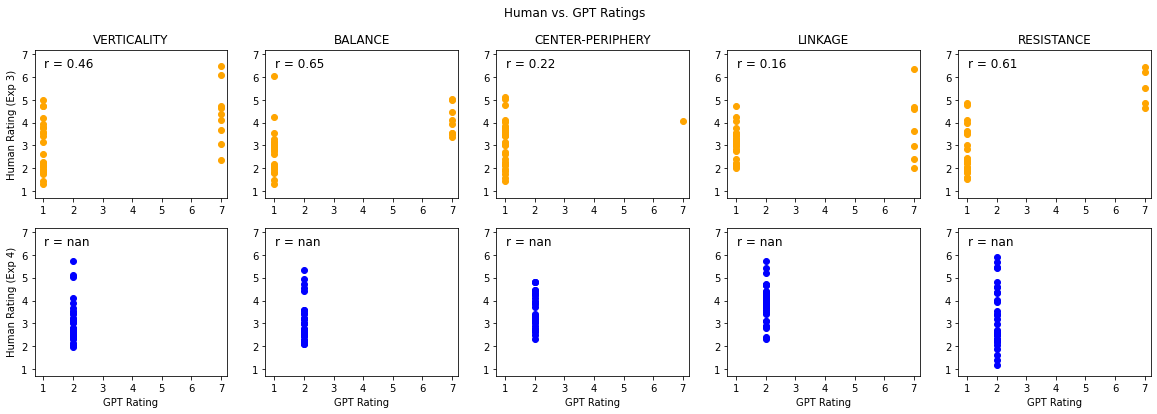

In [161]:
make_scatter_plots(full_history_results_exp3, full_history_results_exp4, "Human vs. GPT Ratings")

# Full Questionaire Experiments (single Image Schema)

In [39]:
model="gpt-3.5-turbo-0613"
history_results_exp3={}
history_results_exp4={}
for key in DEFINITIONS:
    print("\n", key)
    history_results_exp3[key] = []
    history_results_exp4[key] = []
    gpt_c3=gpt_with_nearly_full_instructions(model=model, image_schema=key, stimuli=STIMULI_EXP3) 
    time.sleep(RATE_LIMIT)
    gpt_c4=gpt_with_nearly_full_instructions(model=model, image_schema=key, stimuli=STIMULI_EXP4)
    time.sleep(RATE_LIMIT)
    # extract numbers from response
    c3=gpt_c3["choices"][0]["message"]["content"]
    c4=gpt_c4["choices"][0]["message"]["content"]
    print("\nExperiment 3")
    print(c3)
    print("\nExperiment 4")
    print(c4)
    c3=c3.split("\n")
    c4=c4.split("\n")
    c3=[i.split(":")[1].strip() for i in c3]
    c4=[i.split(":")[1].strip() for i in c4]
    history_results_exp3[key]=c3
    history_results_exp4[key]=c4

for IS in history_results_exp3:
    # turn list of strings (e.g. ["1","2"]) into ints (e.g. [1,2])
    history_results_exp3[IS] = [int(rating) for rating in history_results_exp3[IS]]
for IS in history_results_exp4:
    # turn list of strings (e.g. ["1","2"]) into ints (e.g. [1,2])
    history_results_exp4[IS] = [int(rating) for rating in history_results_exp4[IS]]


 VERTICALITY

Experiment 3
1: 6
2: 4
3: 6
4: 5
5: 6
6: 6
7: 6
8: 4
9: 3
10: 2
11: 6
12: 6
13: 2
14: 5
15: 6
16: 6
17: 6
18: 5
19: 6
20: 5
21: 5
22: 6
23: 6
24: 6
25: 5
26: 5
27: 6
28: 4
29: 6
30: 6
31: 4
32: 6

Experiment 4
1: 2
2: 1
3: 6
4: 2
5: 4
6: 5
7: 3
8: 2
9: 4
10: 2
11: 7
12: 7
13: 1
14: 4
15: 2
16: 7
17: 2
18: 3
19: 2
20: 4
21: 3
22: 2
23: 7
24: 7
25: 4
26: 5
27: 5
28: 2
29: 6
30: 1
31: 3
32: 6

 BALANCE

Experiment 3
1: 1
2: 2
3: 6
4: 5
5: 6
6: 6
7: 6
8: 4
9: 3
10: 2
11: 1
12: 3
13: 2
14: 4
15: 6
16: 5
17: 6
18: 5
19: 6
20: 4
21: 5
22: 5
23: 6
24: 4
25: 4
26: 4
27: 6
28: 3
29: 6
30: 6
31: 4
32: 5

Experiment 4
1: 1
2: 2
3: 6
4: 1
5: 4
6: 6
7: 5
8: 4
9: 6
10: 2
11: 1
12: 3
13: 1
14: 4
15: 5
16: 3
17: 2
18: 3
19: 4
20: 4
21: 3
22: 1
23: 3
24: 3
25: 4
26: 5
27: 6
28: 2
29: 5
30: 2
31: 3
32: 6

 CENTER-PERIPHERY

Experiment 3
1: 1
2: 4
3: 5
4: 6
5: 6
6: 6
7: 6
8: 4
9: 3
10: 4
11: 2
12: 3
13: 4
14: 4
15: 5
16: 6
17: 5
18: 5
19: 6
20: 4
21: 5
22: 6
23: 3
24: 4
25: 4
26: 5
27: 6
28

In [ ]:
# history_results_expX to pkl
with open('history_results_exp4.pkl', 'wb') as f:
    pickle.dump(history_results_exp4, f)

with open('history_results_exp3.pkl', 'wb') as f:
    pickle.dump(history_results_exp3, f)   

In [133]:
print_correlations(history_results_exp3, history_results_exp4)

VERTICALITY
Experiment 3: SpearmanrResult(correlation=0.39248203951590666, pvalue=0.02629062682584727)
Experiment 4: SpearmanrResult(correlation=0.18066380733387408, pvalue=0.3224178507761486)

BALANCE
Experiment 3: SpearmanrResult(correlation=0.13341795203218007, pvalue=0.46663645952245225)
Experiment 4: SpearmanrResult(correlation=0.22565818366289975, pvalue=0.21430256336588713)

CENTER-PERIPHERY
Experiment 3: SpearmanrResult(correlation=0.45838062223891046, pvalue=0.008328988276605017)
Experiment 4: SpearmanrResult(correlation=0.03487005828984612, pvalue=0.8497289613404104)

LINKAGE
Experiment 3: SpearmanrResult(correlation=0.640534792236373, pvalue=7.853556238578637e-05)
Experiment 4: SpearmanrResult(correlation=0.4047371197296721, pvalue=0.021575491456038046)

RESISTANCE
Experiment 3: SpearmanrResult(correlation=0.499589546870746, pvalue=0.0036003409174275905)
Experiment 4: SpearmanrResult(correlation=0.7112514570467381, pvalue=5.0445279741929784e-06)



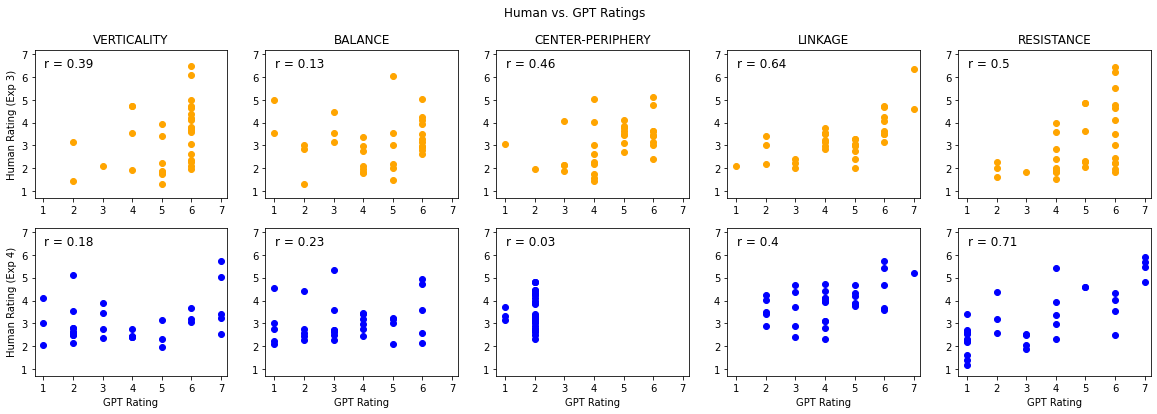

In [124]:
make_scatter_plots(history_results_exp3, history_results_exp4, "Human vs. GPT Ratings")

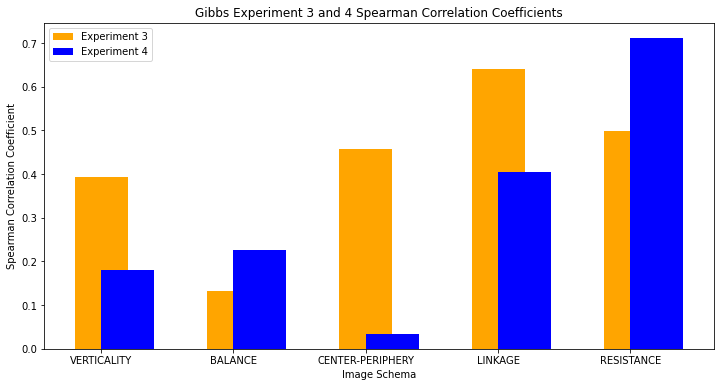

In [125]:
make_bar_plots(model_result_dict_3=history_results_exp3, model_result_dict_4=history_results_exp4, title="Gibbs Experiment 3 and 4 Spearman Correlation Coefficients")

# Single Prompts Experiments

We generate the answers with the following models:
- text-davinci-003 (GPT 3.5 instruction-tuned)
- davinci-002   (Base GPT-3)
- llama2 70B   
- llama2 70B Chat 

In [249]:
print(prompts_exp3["VERTICALITY"][1])
print(prompts_exp2["VISIBILITY"][1])

Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.
How strongly is the phrase "stand out in several sports" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?
In the case of the use of "on" in "the book is on the desk": the VISIBILITY relation refers to the book being visible on the desk.
On a scale from 1 (not at all appropriate) to 7 (very appropriate), how appropriate is the concept VISIBILITY in regards to the phrase: "There is a physician on call"?


In [162]:
def get_all_completions(model, prompts, prompt_ending, save_name="", verbose=False):
    '''
    for all image schemas and all items, get completions and completions_logprobs

    model: str, the model to use
    prompts: dict, the prompts to use, with image schemas as keys and lists of prompts as values
    prompt_ending: str, the prompt ending to append to each prompt
    save_name: str, the name to use when saving the results as pickle
    verbose: bool, whether to print the prompts
    '''
    completions={}
    completions_logprobs={}
    for key in prompts:
        completions[key]=[]
        completions_logprobs[key]=[]
        for i in range(len(prompts[key])):
            if verbose: print("Prompt:", prompts[key][i])
            completions[key].append(gpt_complete(prompt=prompts[key][i], model=model, max_tokens=10, prompt_ending=prompt_ending))
            time.sleep(RATE_LIMIT)
            completions_logprobs[key].append(gpt_complete_proba(prompt=prompts[key][i], model=model, prompt_ending=prompt_ending))
        print("Finished with", key)
    
    # saver results as pickle
    if save_name!="":
        date = datetime.datetime.now().strftime("%Y-%m-%d")
        with open(save_name + '_' + model + '_' + date + '.pkl', 'wb') as f:
            pickle.dump(completions, f)
        with open(save_name + '_logprobs_' + model + '_' + date + '.pkl', 'wb') as f:
            pickle.dump(completions_logprobs, f)

    return completions, completions_logprobs

In [264]:
def extract_completions(completions):   
    '''
    extract the model's actual scores from the completions (i.e. digits from string) and return them in a dict, the same format as the human data.
    print the unedited output to check manually for errors. 
    '''
    completions_clean = {}
    for key in completions:
        completions_clean[key]=[]
        for i in range(len(completions[key])):
            text_output=completions[key][i]["choices"][0]["text"]
            print(text_output)
            try:
                clean_item = int(re.findall(r'\d+', text_output)[0])
            except:
                print("error with item: ", clean_item)
                clean_item = 0
            completions_clean[key].append(clean_item)
    return completions_clean


def extract_completions_logprob(completions_logprob):
    '''
    same but for the logprob version
    '''
    completions_clean = {}
    for key in completions_logprob:
        completions_clean[key]=[]
        for i in range(len(completions_logprob[key])):
            avg_score=completions_logprob[key][i][1]
            completions_clean[key].append(avg_score)
    return completions_clean
    

## Experiment 2

In [258]:
print(prompts_exp2["VISIBILITY"][1])
print(prompts_exp3["VERTICALITY"][1])

In the case of the use of "on" in "the book is on the desk": the VISIBILITY relation refers to the book being visible on the desk.
On a scale from 1 (not at all appropriate) to 7 (very appropriate), how appropriate is the concept VISIBILITY in regards to the phrase: "There is a physician on call"?
Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.
How strongly is the phrase "stand out in several sports" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?


In [262]:
if False: 
    completions_exp2, completions_logprobs_exp2 = get_all_completions(model="text-davinci-003", prompts=prompts_exp2, prompt_ending=" Only answer with the score: \n\n", save_name="completions_exp2", verbose=True)

Prompt: In the case of the use of "on" in "the book is on the desk": the SUPPORT relation refers to the desk supporting the book.
On a scale from 1 (not at all appropriate) to 7 (very appropriate), how appropriate is the concept SUPPORT in regards to the phrase: "The family depends on the father"?
['In', ' the', ' case', ' of', ' the', ' use', ' of', ' "', 'on', '"', ' in', ' "', 'the', ' book', ' is', ' on', ' the', ' desk', '":', ' the', ' SUPPORT', ' relation', ' refers', ' to', ' the', ' desk', ' supporting', ' the', ' book', '.', '\n', 'On', ' a', ' scale', ' from', ' 1', ' (', 'not', ' at', ' all', ' appropriate', ')', ' to', ' 7', ' (', 'very', ' appropriate', '),', ' how', ' appropriate', ' is', ' the', ' concept', ' SUPPORT', ' in', ' regards', ' to', ' the', ' phrase', ':', ' "', 'The', ' family', ' depends', ' on', ' the', ' father', '"?', ' Only', ' answer', ' with', ' the', ' score', ':', ' ', '\n', '\n', '1', '-']
index: 77
log prob: -20.043858
prob: 1.9727092207739203e-0

In [265]:
completions_clean_exp2 = extract_completions(completions_exp2)
completions_clean_exp2_logprobs=extract_completions_logprob(completions_logprobs_exp2)

7
7
1

5
7
7
1
1
1
1
1
1
7
5
7
4
7
1
1
7
1
7
1
1
1
7
1
7
7
7
7
7
7
1
1
7
1
7
3
1
2
2
2
1
1
7
7
1
1
1
2
1
7
7
7
3
7
1
7
1
1
7
2
1
7
3
1
7
7
7
7
7
7
1
7
7
1

5
7
7
4
3
7
7
1
1
4
6
1
7
7
7
7
7
1
7
1
1
7
4
1
7
4
7
7
7
7
3
1
7
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
7
1
7
1
1
1
1
1
7
4
7
7
7
7
1
1
7
1
1
7
1
7
7
4
2
2
1
1
1
2
7
1
1
1
1
1
1
7
1
7
1
1
1
7
1
7
7
7
7
4
7
1
7
7
1


In [270]:
for k in completions_clean_exp2:
    print(k, len(completions_clean_exp2[k]))

SUPPORT 37
PRESSURE 37
CONSTRAINT 37
COVERING 37
VISIBILITY 37


In [271]:
save_generations_to_csv(completions=completions_exp2, stimuli=STIMULI_EXP2, exp_name="single_prompt_exp2_davinci003", completions_clean=completions_clean_exp2)
save_generations_to_csv(stimuli=STIMULI_EXP2, exp_name="single_prompt_exp2_davinci003_logprobs", completions_clean=completions_clean_exp2_logprobs)

Saved as df_single_prompt_exp2_davinci003_2023-10-19.csv
Saved as df_single_prompt_exp2_davinci003_logprobs_2023-10-19.csv


In [273]:
# correlations
print_correlations(completions_clean_exp2, exp_2_df, correlation_type="spearman")
print_correlations(completions_clean_exp2_logprobs, exp_2_df, correlation_type="spearman")
# mean absolute error
print("Without logprobs:")
get_mean_absolute_error(completions_clean_exp2, exp_2_df)
print("\nWith logprob averaging:")
get_mean_absolute_error(completions_clean_exp2_logprobs, exp_2_df)

Spearman correlations per IS:
SUPPORT SpearmanrResult(correlation=0.012875566709006995, pvalue=0.9397103317675539)
PRESSURE SpearmanrResult(correlation=0.24355638564929363, pvalue=0.14632787367914407)
CONSTRAINT SpearmanrResult(correlation=0.6153206657137973, pvalue=5.056974441202151e-05)
COVERING SpearmanrResult(correlation=0.4324152248952376, pvalue=0.007520922641586825)
VISIBILITY SpearmanrResult(correlation=0.6863125330273422, pvalue=2.7418868131205064e-06)
Spearman correlations per IS:
SUPPORT SpearmanrResult(correlation=0.1812036918610684, pvalue=0.28313459436006144)
PRESSURE SpearmanrResult(correlation=0.2542393140835599, pvalue=0.12889509908970212)
CONSTRAINT SpearmanrResult(correlation=0.6406410852742016, pvalue=1.945965290900166e-05)
COVERING SpearmanrResult(correlation=0.17849732720740483, pvalue=0.29050750451769614)
VISIBILITY SpearmanrResult(correlation=0.8014226493782796, pvalue=2.5331766943569605e-09)
Without logprobs:
The mean absolute error for each image schema is: 
S

## Experiment 3

In [163]:
if False: 
    completions, completions_logprobs = get_all_completions(model="text-davinci-003", prompts=prompts_exp3, prompt_ending=" Only answer with the score: \n\n", save_name="completions_exp3", verbose=False)

['Consider', ' the', ' notion', ' of', ' V', 'ERT', 'ICAL', 'ITY', '.', ' Vertical', 'ity', ' refers', ' to', ' the', ' sense', ' of', ' an', ' extension', ' along', ' an', ' up', '—', 'down', ' orientation', '.', '\n', 'How', ' strongly', ' is', ' the', ' phrase', ' "', 'stand', ' at', ' attention', '"', ' related', ' to', ' this', ' notion', ' on', ' a', ' scale', ' from', ' 1', ' (', 'not', ' at', ' all', ' related', ')', ' to', ' 7', ' (', 'very', ' strongly', ' related', ')?', ' Only', ' answer', ' with', ' the', ' score', ':', ' ', '\n', '\n', '1']
index: 67
log prob: -18.596075
prob: 8.391261249951569e-09
token: 1

['Consider', ' the', ' notion', ' of', ' V', 'ERT', 'ICAL', 'ITY', '.', ' Vertical', 'ity', ' refers', ' to', ' the', ' sense', ' of', ' an', ' extension', ' along', ' an', ' up', '—', 'down', ' orientation', '.', '\n', 'How', ' strongly', ' is', ' the', ' phrase', ' "', 'stand', ' at', ' attention', '"', ' related', ' to', ' this', ' notion', ' on', ' a', ' scale', '

In [197]:
completions_clean_exp3 = extract_completions(completions)
completions_clean_exp3_logprobs=extract_completions_logprob(completions_logprobs)

7
1
7
1
1
3
3
1
4
1
7
4
1
1
5
7
7
1
3
1
7
1
1
7
1
4
1
1
7
7
7
1
7
1
7
1
4
7
3
1
4
1
1
1
1
1
7
1
3
1
3
1
1
1
1
1
1
4
1
1
7
1
1
1
7
7
7
3
7
7
7
1
1
1
1
1
1
1
7
7
7
7
7
1
1
7
4
1
1
7
1
1
7
7
7
1
7
4
4
3
7
7
7
1
1
7
1
4
1
7
7
7
3
7
7
1
7
7
3
1
1
7
7
1
7
7
7
4
7
3
7
7
7
7
1
1
1
1
1
1
1
1
7
3
1
7
3
7
4
3
1
1
1
3
1
1
7
1
3
1


In [213]:
save_generations_to_csv(completions=completions, stimuli=STIMULI_EXP3, exp_name="single_prompt_exp3_davinci003", completions_clean=completions_clean_exp3)
save_generations_to_csv(stimuli=STIMULI_EXP3, exp_name="single_prompt_exp3_davinci003_logprobs", completions_clean=completions_clean_exp3_logprobs)

Saved as df_single_prompt_exp3_davinci003_2023-10-18.csv
Saved as df_single_prompt_exp3_davinci003_logprobs_2023-10-18.csv


In [254]:
print_correlations(completions_clean_exp3, exp_3_df, correlation_type="spearman")
print_correlations(completions_clean_exp3_logprobs, exp_3_df, correlation_type="spearman")
print("\nWithout logprobs:")
get_mean_absolute_error(completions_clean_exp3, exp_3_df)
print("\nWith logprob averaging:")
get_mean_absolute_error(completions_clean_exp3_logprobs, exp_3_df)

Spearman correlations per IS:
VERTICALITY SpearmanrResult(correlation=0.5312418401450295, pvalue=0.0017566795788170396)
BALANCE SpearmanrResult(correlation=0.3675016615804176, pvalue=0.038524548150578354)
CENTER-PERIPHERY SpearmanrResult(correlation=0.8193051957000557, pvalue=9.832390206890013e-09)
LINKAGE SpearmanrResult(correlation=0.45788470109704293, pvalue=0.008408413046431747)
RESISTANCE SpearmanrResult(correlation=0.7064193811625793, pvalue=6.239503888029979e-06)
Spearman correlations per IS:
VERTICALITY SpearmanrResult(correlation=0.5468048617096709, pvalue=0.0012025894995613964)
BALANCE SpearmanrResult(correlation=0.34836819357311755, pvalue=0.05070567425444937)
CENTER-PERIPHERY SpearmanrResult(correlation=0.8066734194477555, pvalue=2.4752100928420837e-08)
LINKAGE SpearmanrResult(correlation=0.5090343841920751, pvalue=0.00292705079692928)
RESISTANCE SpearmanrResult(correlation=0.7206832887437716, pvalue=3.289872545915162e-06)

Without logprobs:
The mean absolute error for each

In [231]:
# create random fake completions and compare the mean absolute error + the correlations
random_completions={}
for key in DEFINITIONS:
    random_completions[key]=[]
    for i in range(len(exp_3_df[key])):
        random_completions[key].append(random.randint(1, 7))

get_mean_absolute_error(random_completions, exp_3_df)
print_correlations(random_completions, exp_3_df)


The mean absolute error for each image schema is: 
VERTICALITY 2.2265625
BALANCE 2.1587499999999995
CENTER-PERIPHERY 2.2109375
LINKAGE 2.1037500000000002
RESISTANCE 2.1903125
Spearman correlations per IS:
VERTICALITY SpearmanrResult(correlation=-0.22357781042844774, pvalue=0.21867026872806294)
BALANCE SpearmanrResult(correlation=-0.295425525988459, pvalue=0.10068034132837984)
CENTER-PERIPHERY SpearmanrResult(correlation=-0.08809398529121891, pvalue=0.6316241628155896)
LINKAGE SpearmanrResult(correlation=0.03151691891309706, pvalue=0.8640384951261608)
RESISTANCE SpearmanrResult(correlation=0.09305147069414868, pvalue=0.6124793853967807)


## Experiment 4

In [234]:
if False: 
    completions_exp4, completions_logprobs_exp4 = get_all_completions(model="text-davinci-003", prompts=prompts_exp4, prompt_ending=" Only answer with the score: \n\n", save_name="completions_exp4", verbose=False)

['Consider', ' the', ' notion', ' of', ' V', 'ERT', 'ICAL', 'ITY', '.', ' Vertical', 'ity', ' refers', ' to', ' the', ' sense', ' of', ' an', ' extension', ' along', ' an', ' up', '—', 'down', ' orientation', '.', '\n', 'How', ' strongly', ' is', ' the', ' phrase', ' "', 'be', ' at', ' attention', '"', ' related', ' to', ' this', ' notion', ' on', ' a', ' scale', ' from', ' 1', ' (', 'not', ' at', ' all', ' related', ')', ' to', ' 7', ' (', 'very', ' strongly', ' related', ')?', ' Only', ' answer', ' with', ' the', ' score', ':', ' ', '\n', '\n', '1']
index: 67
log prob: -16.437761
prob: 7.263920842105422e-08
token: 1

['Consider', ' the', ' notion', ' of', ' V', 'ERT', 'ICAL', 'ITY', '.', ' Vertical', 'ity', ' refers', ' to', ' the', ' sense', ' of', ' an', ' extension', ' along', ' an', ' up', '—', 'down', ' orientation', '.', '\n', 'How', ' strongly', ' is', ' the', ' phrase', ' "', 'be', ' at', ' attention', '"', ' related', ' to', ' this', ' notion', ' on', ' a', ' scale', ' from'

In [235]:
completions_clean_exp4 = extract_completions(completions_exp4)
completions_clean_exp4_logprobs=extract_completions_logprob(completions_logprobs_exp4)

7
1
7
1
1
1
1
1
1
1
7
1
1
1
4
1
1
1
3
1
1
1
1
7
1
7
1
1
4
1
7
1
4
1
7
1
1
7
1
1
4
1
1
1
1
1
5
1
1
1
4
1
7
1
1
1
1
7
4
1
4
1
1
1
7
1
4
1
7
7
7
1
1
1
1
1
1
7
7
7
7
7
5
1
1
7
3
1
1
7
1
1
7
7
7
1
1
3
4
1
7
7
7
1
1
1
1
7
1
4
7
3
1
7
3
3
5
7
1
1
1
7
7
1
5
7
7
4
7
1
7
7
4
7
1
1
7
1
1
1
1
1
5
1
1
7
3
7
3
1
1
1
1
3
1
1
7
1
1
7


In [236]:
save_generations_to_csv(completions=completions_exp4, stimuli=STIMULI_EXP3, exp_name="single_prompt_exp4_davinci003", completions_clean=completions_clean_exp4)
save_generations_to_csv(stimuli=STIMULI_EXP4, exp_name="single_prompt_exp4_davinci003_logprobs", completions_clean=completions_clean_exp4_logprobs)

Saved as df_single_prompt_exp4_davinci003_2023-10-18.csv
Saved as df_single_prompt_exp4_davinci003_logprobs_2023-10-18.csv


In [237]:
# correlations
print_correlations(completions_clean_exp4, exp_4_df)
print_correlations(completions_clean_exp4_logprobs, exp_4_df)
# mean absolute error
print("Without logprobs:")
get_mean_absolute_error(completions_clean_exp4, exp_4_df)
print("\nWith logprob averaging:")
get_mean_absolute_error(completions_clean_exp4_logprobs, exp_4_df)

Spearman correlations per IS:
VERTICALITY SpearmanrResult(correlation=0.4905013539975237, pvalue=0.004370296444313438)
BALANCE SpearmanrResult(correlation=0.4963768177302381, pvalue=0.0038579504170745157)
CENTER-PERIPHERY SpearmanrResult(correlation=0.6699620198628766, pvalue=2.7377071113123408e-05)
LINKAGE SpearmanrResult(correlation=0.6076250110002916, pvalue=0.0002257328800802195)
RESISTANCE SpearmanrResult(correlation=0.613513048203053, pvalue=0.00018849413186170787)
Spearman correlations per IS:
VERTICALITY SpearmanrResult(correlation=0.5678130468309934, pvalue=0.0006997928980743908)
BALANCE SpearmanrResult(correlation=0.5821718368031533, pvalue=0.0004731735927284831)
CENTER-PERIPHERY SpearmanrResult(correlation=0.7327771825408153, pvalue=1.8534825311058687e-06)
LINKAGE SpearmanrResult(correlation=0.5919135122732453, pvalue=0.00035905464763618706)
RESISTANCE SpearmanrResult(correlation=0.7239893939543606, pvalue=2.820590587256666e-06)
Without logprobs:
The mean absolute error for 

## Plotting

In [310]:
# how big is the difference when using logprob averaging?
print("\nExperiment 2:")
get_mean_absolute_error(completions_clean_exp2, completions_clean_exp2_logprobs)
print("\nExperiment 3:")
get_mean_absolute_error(completions_clean_exp3, completions_clean_exp3_logprobs)
print("\nExperiment 4:")
get_mean_absolute_error(completions_clean_exp4, completions_clean_exp4_logprobs)


Experiment 2:
The mean absolute error for each image schema is: 
SUPPORT 0.5474568620338988
PRESSURE 0.4206053416524155
CONSTRAINT 0.3769131011273762
COVERING 0.23106340288452404
VISIBILITY 0.44818815163176273

Experiment 3:
The mean absolute error for each image schema is: 
VERTICALITY 0.253525651979948
BALANCE 0.3375683414003554
CENTER-PERIPHERY 0.5833259490262679
LINKAGE 0.3445448829863865
RESISTANCE 0.3778412002022125

Experiment 4:
The mean absolute error for each image schema is: 
VERTICALITY 0.3098702671255624
BALANCE 0.37217551136829075
CENTER-PERIPHERY 0.5968953036838862
LINKAGE 0.29825098539468725
RESISTANCE 0.3250758973405232


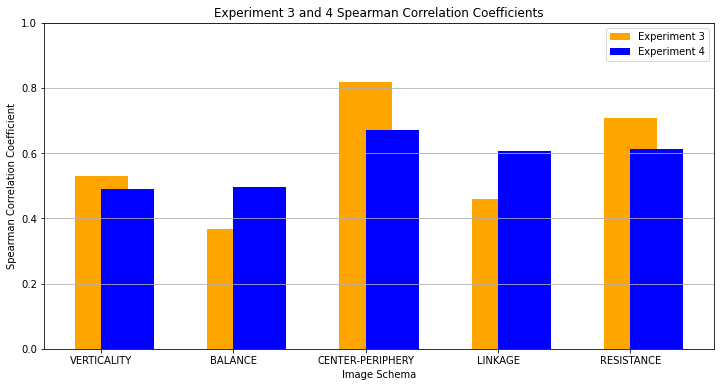

In [390]:
# make bar plot without logprob averaging
make_bar_plots_gibbs(model_result_dict_3=completions_clean_exp3, model_result_dict_4=completions_clean_exp4, title="Experiment 3 and 4 Spearman Correlation Coefficients")

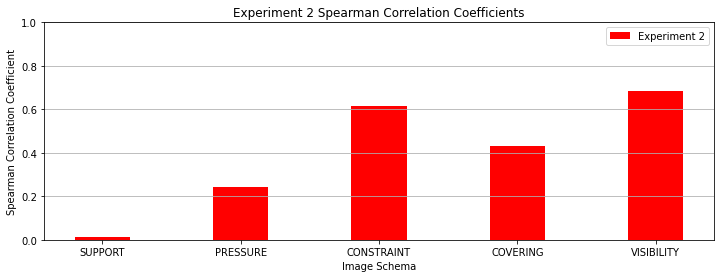

In [391]:
make_bar_plots_beitel(completions_clean_exp2, title="Experiment 2 Spearman Correlation Coefficients")

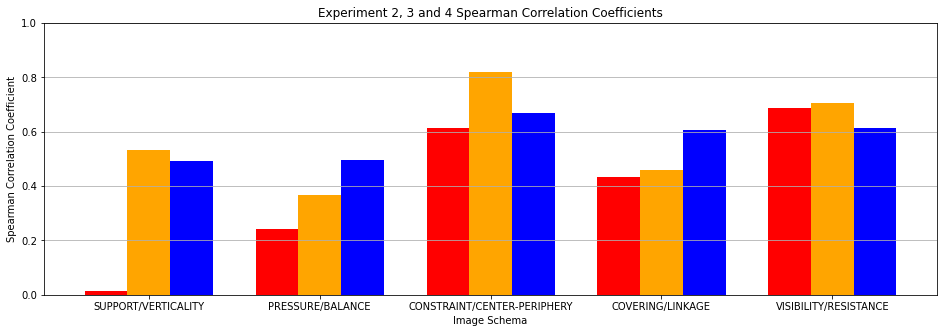

In [392]:
make_bar_plots_all(model_result_dict_2=completions_clean_exp2, model_result_dict_3=completions_clean_exp3, model_result_dict_4=completions_clean_exp4, title="Experiment 2, 3 and 4 Spearman Correlation Coefficients")

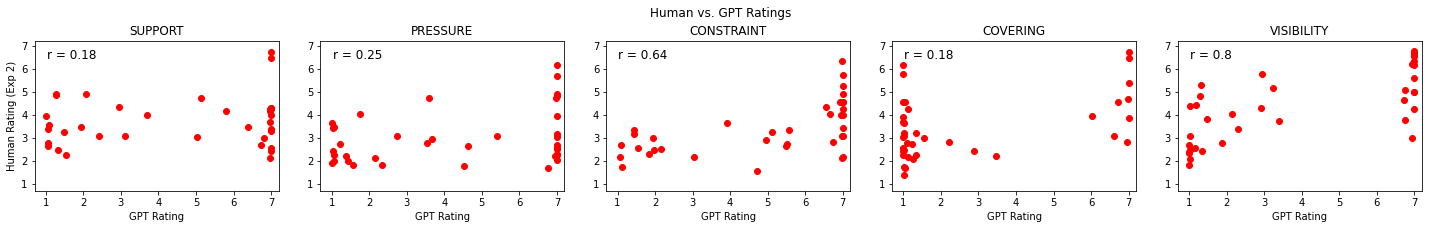

In [396]:
# with logprobs averaging
make_scatter_plots_beitel(model_result_dict_2=completions_clean_exp2_logprobs, title="Human vs. GPT Ratings") 

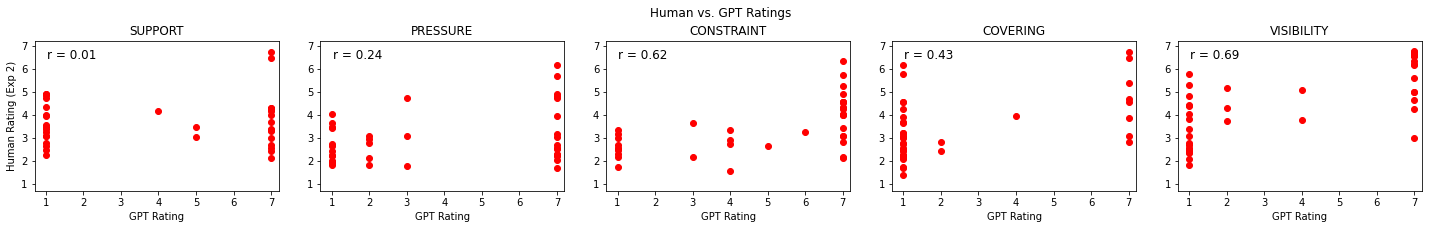

In [397]:
# with logprobs averaging
make_scatter_plots_beitel(model_result_dict_2=completions_clean_exp2, title="Human vs. GPT Ratings") 

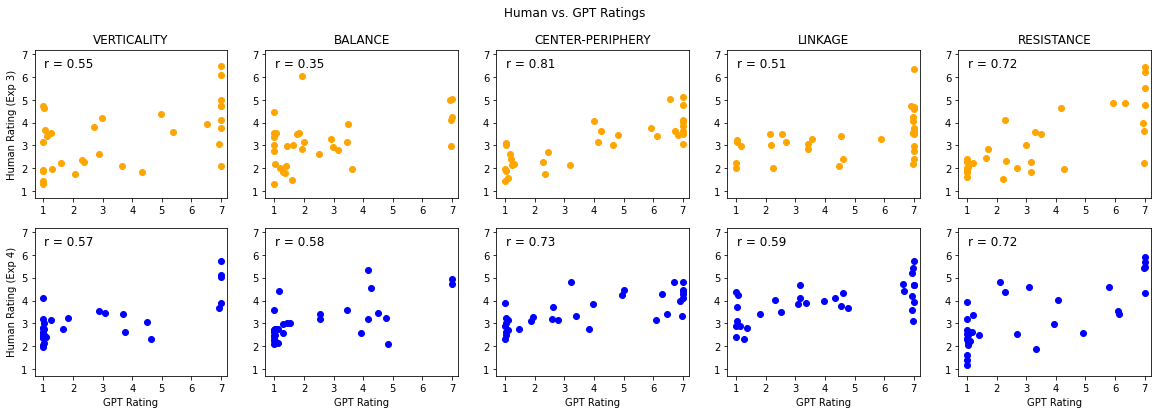

In [275]:
# with logprobs averaging
make_scatter_plots_gibbs(model_result_dict_3=completions_clean_exp3_logprobs, model_result_dict_4=completions_clean_exp4_logprobs, title="Human vs. GPT Ratings") 

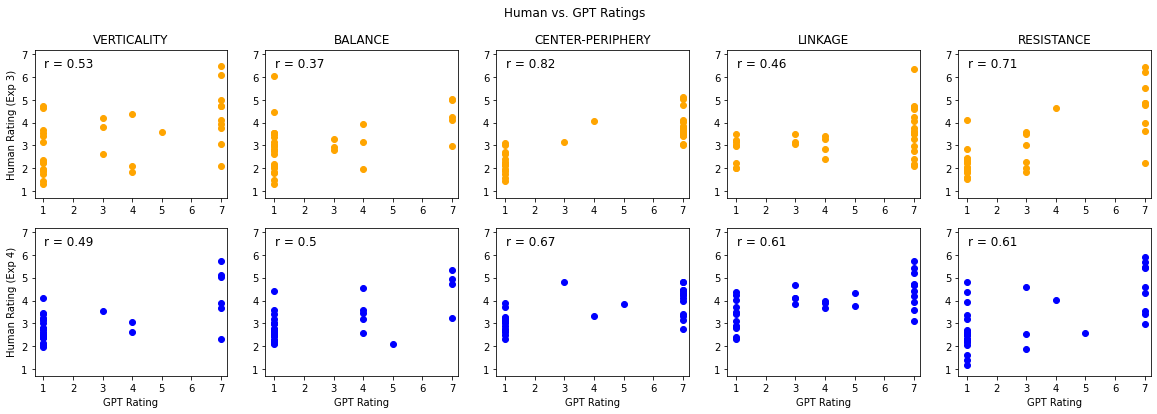

In [276]:
# without logprobs averaging
make_scatter_plots_gibbs(model_result_dict_3=completions_clean_exp3, model_result_dict_4=completions_clean_exp4, title="Human vs. GPT Ratings") 

next cell is old and can be deleted

In [ ]:
model="text-davinci-003"
completions_exp2={"SUPPORT": [], "PRESSURE": [], "CONSTRAINT": [], "COVERING": [], "VISIBILITY": []}
completions_exp2_logprobs={"SUPPORT": [], "PRESSURE": [], "CONSTRAINT": [], "COVERING": [], "VISIBILITY": []}

if model == "text-davinci-003":
    prompt_ending=""
if model == "davinci-002":
    prompt_ending=" I choose the number "

for i in range(len(STIMULI_EXP2)):
    for k in completions_exp2:
        completions_exp2[k].append(gpt_complete(prompts_exp2[k][i], model, max_tokens=5, prompt_ending=prompt_ending))
        #TODO add logprob completion here as well 
        #completions_exp2_logprobs[k].append(gpt_complete_proba(prompts_exp3[k][i], model, prompt_ending=prompt_ending))
        time.sleep(RATE_LIMIT)

date=datetime.datetime.now().strftime("%Y-%m-%d")
save_name="completions_exp2_"+model+"_"+date+".pkl"
save_name_logprobs="completions_exp2_logprobs_"+model+"_"+date+".pkl"
with open(save_name, 'wb') as f:
    pickle.dump(completions_exp2, f)
with open(save_name_logprobs, 'wb') as f:
    pickle.dump(completions_exp2_logprobs, f)

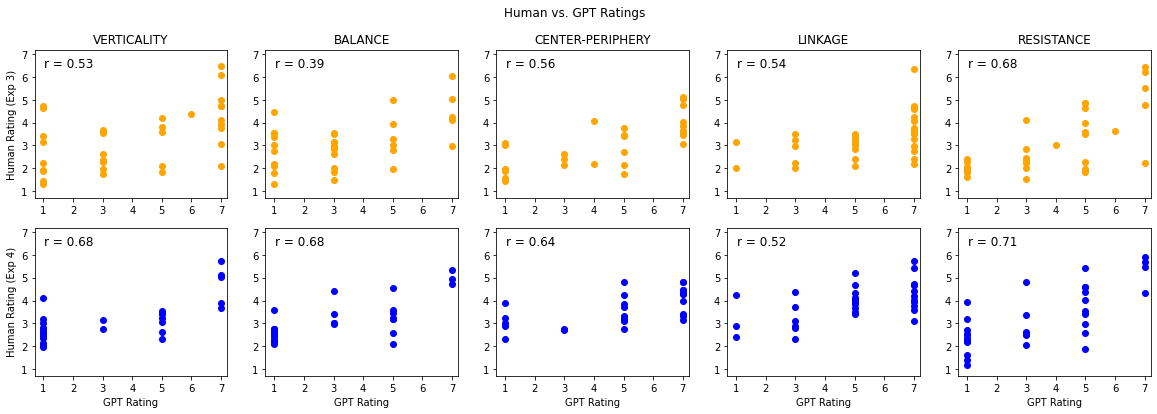

In [16]:
# OLD RESULTS FOR COMPARISION (what was the prompt ending here? none?)
make_scatter_plots(model_result_dict_3=completions_exp3_clean, model_result_dict_4=completions_exp4_clean, title="Human vs. GPT Ratings")

## Linear Discriminant Analysis

We repeate the analysis from the paper but this time with the numbers generated from GPT instead of humans

Problem: The paper scores can not be reproduced!

In [146]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 

from sklearn.metrics import accuracy_score

In [105]:
cluster_1=["one-night stand", "let the mixture stand", "a standing ovation", "on the witness stand", "the police told them to stand back", "stand at attention", "let the issue stand", "stand out in several sports", "the boss always stands over me", "to stand the test of time", "don't stand for such treatment"]
cluster_2=["to stand in someone else's shoes", "the clock stands on the mantle", "he stands committed", "we stand on 30 years of experience", "united we stand", "stand on shaky ground", "to stand firm", "stand in awe", "to stand to profit"]
cluster_3=["stand by your man", "to stand accused", "the house stands in the clearing", "he stands six-foot nine", "the barometer stands at 30 inches", "to stand against great odds", "they did nothing but stand around", "the engine can't stand the constant wear", "the part stands for the whole", "it stands to reason", "get stood up for a date", "as the matter now stands"]

In [149]:
# LDA with GPT data 
y = []
for s in STIMULI_EXP3:
    if s in cluster_1:
        y.append(0)
    elif s in cluster_2:
        y.append(1)
    elif s in cluster_3:
        y.append(2)
    else:
        print('error regarding:', s)

x_exp3 = []
x_exp4 = []
for i in range(len(STIMULI_EXP4)):
    schema_profile = []
    for k in completions_exp4_clean:
        schema_profile.append(completions_exp4_clean[k][i])
    x_exp4.append(schema_profile)


clf = QuadraticDiscriminantAnalysis()
clf.fit(x_exp4, y)
y_pred4 = clf.predict(x_exp4)
print('accuracy exp4:', accuracy_score(y_true=y, y_pred=y_pred4))





accuracy exp4: 0.84375


In [147]:
# LDA with original participant data
x_original3 = []
x_original4 = []
for s in STIMULI_EXP3:
    schema_profile = exp_3_df[exp_3_df['Stimulus'] == s].iloc[:, 1:6].values[0].tolist()
    x_original3.append(schema_profile)
for s in STIMULI_EXP4:
    schema_profile = exp_4_df[exp_4_df['Stimulus'] == s].iloc[:, 1:6].values[0].tolist()
    x_original4.append(schema_profile)

# LDA with participant data with IS
clf = QuadraticDiscriminantAnalysis()
clf.fit(x_original3, y)
y_pred3 = clf.predict(x_original3)
print('accuracy original exp3:', accuracy_score(y_true=y, y_pred=y_pred3))

clf.fit(x_original4, y)
y_pred4 = clf.predict(x_original4)
print('accuracy original exp4:', accuracy_score(y_true=y, y_pred=y_pred4))



accuracy original exp3: 0.6875
accuracy original exp4: 0.71875


In [138]:
for i in range(len(x_original4)):
    print(STIMULI_EXP4[i])
    print(x_original4[i])
    print("")

be at attention
[3.4, 5.1, 4.53, 3.3, 3.5]

be distinguished in several sports
[2.2, 3.0, 4.43, 3.73, 4.67]

to hold firm
[5.47, 3.67, 4.73, 3.3, 4.0]

don't allow such treatment
[5.9, 2.6, 3.03, 3.13, 4.03]

to pass the test of time
[4.03, 2.4, 3.4, 2.73, 4.2]

united we are strong
[4.33, 3.13, 4.93, 4.27, 5.73]

we are backed up by 30 years experience
[2.5, 2.73, 3.0, 3.13, 5.2]

let the issue remain as is
[3.37, 2.47, 2.97, 2.47, 2.87]

leave the mixture undisturbed
[2.97, 2.43, 3.6, 2.6, 2.33]

have a dale with someone who didn 't show up
[3.93, 2.8, 2.27, 3.87, 4.23]

he measures six-foot nine
[1.6, 5.73, 2.73, 2.3, 2.4]

the clock is on the mantle
[1.17, 3.23, 3.6, 2.77, 3.1]

one-night fling
[2.7, 2.03, 2.1, 3.13, 3.43]

to be in the position to make a profit
[2.03, 2.73, 3.2, 4.27, 3.9]

to be in someone else's shoes
[2.57, 2.63, 2.1, 4.13, 4.67]

on the witness platform
[3.17, 3.4, 2.6, 4.83, 4.1]

be in aw
[2.23, 2.47, 2.57, 3.43, 4.37]

the police told them to get back
[5.43

In [139]:
for i in range(len(x_original3)):
    print(STIMULI_EXP3[i])
    print(x_original3[i])
    print("")

stand at attention
[4.0, 6.08, 5.0, 3.08, 2.08]

stand out in several sports
[2.0, 3.54, 2.83, 5.04, 3.42]

to stand firm
[6.21, 4.13, 5.04, 3.75, 2.83]

don't stand for such treatment
[5.54, 2.21, 3.04, 3.13, 3.08]

to stand the test of time
[4.88, 2.38, 3.92, 3.0, 4.08]

united we stand
[4.79, 4.21, 4.25, 4.78, 6.33]

we stand on 30 years of experience
[2.46, 2.63, 2.92, 3.43, 4.58]

let the issue stand
[2.83, 1.92, 2.08, 3.04, 2.96]

let the mixture stand
[1.54, 2.08, 3.17, 1.88, 2.0]

get stood up for a date
[1.83, 3.17, 3.04, 2.29, 2.17]

he stands six-foot nine
[2.29, 6.5, 3.54, 1.96, 2.0]

the clock stands on the mantle
[2.0, 4.38, 4.46, 2.13, 2.42]

one-night stand
[1.63, 1.46, 1.29, 2.17, 3.04]

to stand to profit
[2.04, 1.75, 1.79, 1.74, 3.54]

to stand in someone else's shoes
[2.25, 3.58, 2.96, 4.13, 4.7]

on the witness stand
[1.83, 2.08, 1.5, 3.63, 2.96]

stand in awe
[2.33, 3.75, 3.29, 3.65, 3.5]

the police told them to stand back
[3.63, 3.42, 2.17, 3.46, 2.74]

stand by